## Lab 1

### Part 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [2]:
# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

# ! pip  install subword-nmt
# ! pip install nltk
# ! pip install torchtext

In [3]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_do_data = '../../datasets/Machine_translation_EN_RU/data.txt'
if not os.path.exists(path_do_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/datasets/Machine_translation_EN_RU/data.txt -O ./data/data.txt -nc
    path_do_data = './data/data.txt'

Dataset not found locally. Downloading from github. Loading special files as well
File ‘./data/data.txt’ already there; not retrieving.


In [4]:
if not os.path.exists('./utils.py'):
    print("utils file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_advanced/Lab1_NLP/utils.py -nc

if not os.path.exists('./my_network.py'):
    print("network file not found locally. Downloading from github.")
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_advanced/Lab1_NLP/my_network.py -nc

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import TranslationDataset, Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import spacy

import random
import math
import time

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from subword_nmt.learn_bpe import learn_bpe
from subword_nmt.apply_bpe import BPE

### Main part
__Here comes the preprocessing. Do not hesitate to use BPE or more complex preprocessing ;)__

In [6]:
tokenizer_W = WordPunctTokenizer()
def tokenize(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

In [7]:
SRC = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize=tokenize,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

dataset = TabularDataset(
    path=path_do_data,
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

In [8]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])

In [9]:
print(f"Number of training examples: {len(train_data.examples)}")
print(f"Number of validation examples: {len(valid_data.examples)}")
print(f"Number of testing examples: {len(test_data.examples)}")

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500


In [10]:
SRC.build_vocab(train_data, min_freq = 3)
TRG.build_vocab(train_data, min_freq = 3)

In [11]:
print(f"Unique tokens in source (ru) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (ru) vocabulary: 9273
Unique tokens in target (en) vocabulary: 6672


Here are tokens from original (RU) corpus:

In [12]:
SRC.vocab.itos[::1000]

['<unk>',
 'главного',
 'ray',
 'необходимо',
 'life',
 'художественный',
 'nine',
 'трогир',
 'двухэтажном',
 'те']

And from target (EN) corpus:

In [13]:
TRG.vocab.itos[::1000]

['<unk>', '41', 'link', 'dressing', 'mlýn', 'sparkling', 'matterhorn']

And here is example from train dataset:

In [14]:
print(vars(train_data.examples[9]))

{'trg': ['wi', '-', 'fi', 'access', 'at', 'the', 'hotel', 'is', 'free', '.'], 'src': ['wi', '-', 'fi', 'предоставляется', 'бесплатно', '.']}


Let's check the length distributions:

Length distribution in Train data


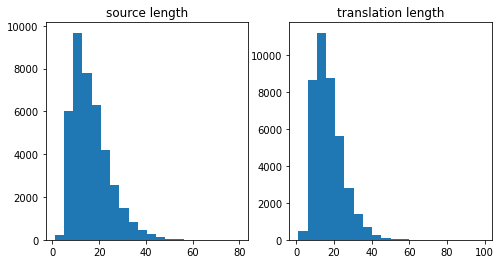

In [15]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

Length distribution in Test data


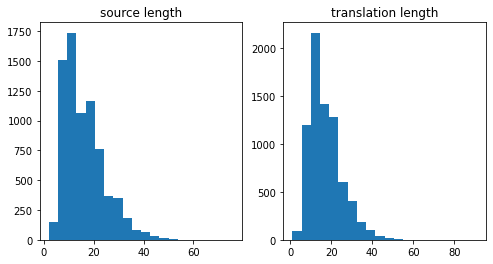

In [16]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("source length")
plt.hist(list(src_length), bins=20);

plt.subplot(1, 2, 2)
plt.title("translation length")
plt.hist(list(trg_length), bins=20);

### Model side
__Here comes simple pipeline of NMT model learning. It almost copies the week03 practice__

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda')

In [18]:
def _len_sort_key(x):
    return len(x.src)

BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device,
    sort_key=_len_sort_key
)

In [19]:
for x in train_iterator:
    break
print(x)
print(x.src.shape, x.trg.shape)


[torchtext.legacy.data.batch.Batch of size 128]
	[.trg]:[torch.cuda.LongTensor of size 37x128 (GPU 0)]
	[.src]:[torch.cuda.LongTensor of size 41x128 (GPU 0)]
torch.Size([41, 128]) torch.Size([37, 128])


In [20]:
import my_network
Encoder = my_network.Encoder
Decoder = my_network.Decoder
Seq2Seq = my_network.Seq2Seq

In [21]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

# dont forget to put the model to the right device
model = Seq2Seq(enc, dec, device).to(device)

In [22]:
def init_weights(m):
    # <YOUR CODE HERE>
    for name, param in m.named_parameters():
        nn.init.uniform_(param, -0.08, 0.08)
        
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(9292, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6746, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=6746, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,922,842 trainable parameters


In [24]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [25]:
def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]
        
        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].view(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        # Let's clip the gradient
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()

        
    return epoch_loss / len(iterator)

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    history = []
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].view(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

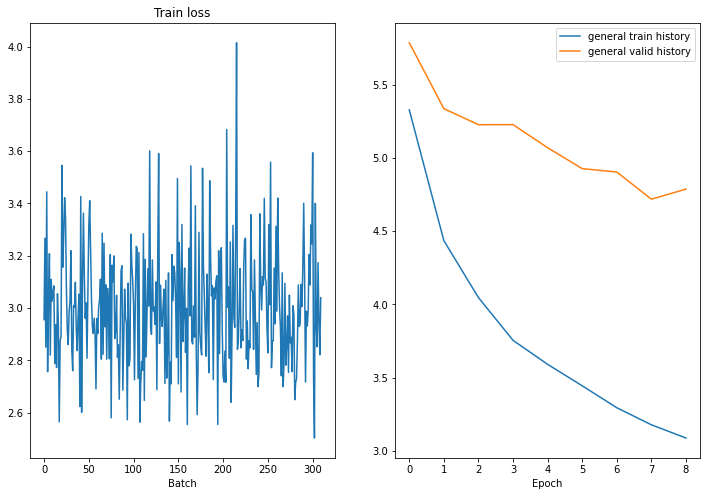

Epoch: 10 | Time: 3m 45s
	Train Loss: 3.002 | Train PPL:  20.120
	 Val. Loss: 4.645 |  Val. PPL: 104.022


In [29]:
for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

__Let's take a look at our network quality__:

In [31]:
import utils
import imp
imp.reload(utils)
generate_translation = utils.generate_translation
remove_tech_tokens = utils.remove_tech_tokens
get_text = utils.get_text
flatten = utils.flatten

In [32]:
batch = next(iter(test_iterator))

In [39]:
for idx in [10,12]:
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]
    generate_translation(src, trg, model, TRG.vocab)

Original: laundry services are available .
Generated: a a - hour front desk .

Original: free wi - fi access is available .
Generated: free wifi is available .



In [40]:
from nltk.translate.bleu_score import corpus_bleu

#     """ Estimates corpora-level BLEU score of model's translations given inp and reference out """
#     translations, _ = model.translate_lines(inp_lines, **flags)
#     # Note: if you experience out-of-memory error, split input lines into batches and translate separately
#     return corpus_bleu([[ref] for ref in out_lines], translations) * 100

In [41]:
import tqdm

In [42]:
original_text = []
generated_text = []
model.eval()
with torch.no_grad():

    for i, batch in tqdm.tqdm(enumerate(test_iterator)):

        src = batch.src
        trg = batch.trg

        output = model(src, trg, 0) #turn off teacher forcing

        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output.argmax(dim=-1)
        
        original_text.extend([get_text(x, TRG.vocab) for x in trg.cpu().numpy().T])
        generated_text.extend([get_text(x, TRG.vocab) for x in output[1:].detach().cpu().numpy().T])

# original_text = flatten(original_text)
# generated_text = flatten(generated_text)

59it [00:05, 10.78it/s]


In [43]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

13.942192593886022

Baseline solution BLEU score is quite low. Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

## custom models

In [108]:
import os
import math
import time
import csv
import shutil
import random
import itertools
from collections import Counter
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### loading & splitting

In [3]:
with open("./data/data.txt") as f:
    pairs = list(csv.reader(f, delimiter="\t", quotechar='"'))
    
print(f"Total number of pairs: {len(pairs)}")
print(f"Sample pair:\n{random.choice(pairs)}")

Total number of pairs: 50000
Sample pair:
['A salt water pool is also offered.', 'Кроме того, в распоряжении гостей бассейн с соленой водой.']


In [4]:
train, test = train_test_split(pairs, test_size=0.05, random_state=1)
train, val = train_test_split(train, test_size=0.15, random_state=1)

print(f"train: {len(train) / len(pairs)}")
print(f"val: {len(val) / len(pairs)}")
print(f"test: {len(test) / len(pairs)}")

train: 0.8075
val: 0.1425
test: 0.05


### preprocessing & tokenizing

In [5]:
class TextPreprocessor:
    
    def __init__(self):
        """
        """
        self.tokenizer = WordPunctTokenizer()

    def __call__(self, text, split=True):
        """
            text: text
            split: if split to tokens
            
            returns: indexes list
        """
        text = text.lower()
        if split:
            text = self.tokenizer.tokenize(text)
        
        return text
    
    def get_unique_vocab(self, corpus, min_freq=3):
        """
            get unique words from a list of sentences
        """
        corpus_words = list(map(self, corpus))
        words = Counter(list(itertools.chain(*corpus_words)))
        words = [word[0] for word in words.items() if word[1] >= 3]
        return words

In [144]:
class TextTokenizer:
    
    def __init__(self, vocab, text_preprocessor):
        """
            vocab: words from training set
        """
        self.pad_token = "<pad>"
        self.sos_token = "<sos>"
        self.eos_token = "<eos>"
        self.unk_token = "<unk>"
        self.additional_tokens = [self.pad_token, self.sos_token, self.eos_token, self.unk_token]
        
        self.text_preprocessor = text_preprocessor
        
        self.vocab = vocab
        self.word2index = dict(zip(
            self.additional_tokens + vocab,
            range(len(vocab) + len(self.additional_tokens))
        ))
        
        self.index2word = {v: k for k, v in self.word2index.items()}

    @property
    def vocab_size(self):
        """
            returns: number of words in dict
        """
        return len(self.word2index)
    
    def detokenize(self, indexes, remove_tech_tokens=True):
        if remove_tech_tokens:
            return " ".join([self.index2word[idx] for idx in indexes if self.index2word[idx] not in self.additional_tokens])
        else:
            return " ".join([self.index2word[idx] for idx in indexes])
    
    def __call__(self, text):
        """
            text: text
            
            returns: indexes list
        """
        text = self.text_preprocessor(text)
        indexes = [self.word2index[self.sos_token]] +\
                  [self.word2index[token] if token in self.word2index else self.word2index[self.unk_token] \
                   for token in text] +\
                  [self.word2index[self.eos_token]]
        
        return indexes

In [145]:
text_preprocessor = TextPreprocessor()

ru_vocab = text_preprocessor.get_unique_vocab([pair[1] for pair in train])
en_vocab = text_preprocessor.get_unique_vocab([pair[0] for pair in train])

ru_tokenizer = TextTokenizer(ru_vocab, text_preprocessor)
en_tokenizer = TextTokenizer(en_vocab, text_preprocessor)
print(f"number of tokens in ru vocab: {ru_tokenizer.vocab_size}")
print(f"number of tokens in en vocab: {en_tokenizer.vocab_size}")

number of tokens in ru vocab: 9367
number of tokens in en vocab: 6738


### dataset & dataloader creation

In [146]:
class TranslationDataset(Dataset):
    
    def __init__(self, src, trg, src_tokenizer, trg_tokenizer):
        """
            src: source language sentences
            trg: target language sentences
            src_tokenizer: source language tokenizer
            trg_tokenizer: target language tokenizer
        """
        self.src = src
        self.trg = trg
        
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        
        self.data = []
        for s, t in zip(src, trg):
            self.data.append((self.src_tokenizer(s), self.trg_tokenizer(t)))
                
    def __len__(self):
        """
            returns: number of pairs
        """
        return len(self.data)
    
    def __getitem__(self, idx):
        """
            returns: ([indexes of source sentence], [indexes of target sentence])
        """
        return self.data[idx]

In [9]:
train_dataset = TranslationDataset(
    src=[pair[1] for pair in train],
    trg=[pair[0] for pair in train],
    src_tokenizer=ru_tokenizer,
    trg_tokenizer=en_tokenizer
)

val_dataset = TranslationDataset(
    src=[pair[1] for pair in val],
    trg=[pair[0] for pair in val],
    src_tokenizer=ru_tokenizer,
    trg_tokenizer=en_tokenizer
)

test_dataset = TranslationDataset(
    src=[pair[1] for pair in test],
    trg=[pair[0] for pair in test],
    src_tokenizer=ru_tokenizer,
    trg_tokenizer=en_tokenizer
)

In [10]:
print(train[-2])
print(train_dataset[-2])
print([ru_tokenizer.word2index[word] for word in text_preprocessor(train[-2][1])])
print(ru_tokenizer.detokenize(train_dataset[-2][0]))
print(en_tokenizer.detokenize(train_dataset[-2][1]))

['The kitchen is equipped with a dishwasher.', 'Кухня оснащена посудомоечной машиной.']
([1, 177, 1559, 427, 428, 20, 2], [1, 80, 171, 6, 170, 8, 9, 178, 22, 2])
[177, 1559, 427, 428, 20]
<sos> кухня оснащена посудомоечной машиной . <eos>
<sos> the kitchen is equipped with a dishwasher . <eos>


In [11]:
src_pad_idx = ru_tokenizer.word2index["<pad>"]
trg_pad_idx = en_tokenizer.word2index["<pad>"]

def collate_fn(batch):
    """
        batch: pair of lists of words indexes
        
        returns: list of src, list of trg
    """
    src, trg = map(list, zip(*batch))
    max_src = max(list(map(len, src)))
    max_trg = max(list(map(len, trg)))
    src = torch.tensor([s + [src_pad_idx] * (max_src - len(s)) for s in src])
    trg = torch.tensor([t + [trg_pad_idx] * (max_trg - len(t)) for t in trg])
    
    return src, trg

In [12]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

batch = next(iter(train_dataloader))
src, trg = batch
print(src.shape)
print(trg.shape)
src

torch.Size([32, 47])
torch.Size([32, 39])


tensor([[  1,   4,   5,  ...,   0,   0,   0],
        [  1,  21,  22,  ...,   0,   0,   0],
        [  1,  34,   3,  ...,   0,   0,   0],
        ...,
        [  1, 259,  23,  ...,   0,   0,   0],
        [  1,  76,  77,  ...,   0,   0,   0],
        [  1, 279, 159,  ...,   0,   0,   0]])

### model

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(
            num_embeddings=input_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, src):
        
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        
        output, (hidden, cell) = self.rnn(embedded)
        
        #outputs = [src sent len, batch size, hid dim * n directions]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #outputs are always from the top hidden layer
        
        return hidden, cell
    

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout
        
        self.embedding = nn.Embedding(
            num_embeddings=output_dim,
            embedding_dim=emb_dim
        )
        
        self.rnn = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hid_dim,
            num_layers=n_layers,
            dropout=dropout,
            batch_first=True
        )
        
        self.out = nn.Linear(
            in_features=hid_dim,
            out_features=output_dim
        )
        
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, input, hidden, cell):
        
        #input = [batch size]
        #hidden = [n layers * n directions, batch size, hid dim]
        #cell = [n layers * n directions, batch size, hid dim]
        
        #n directions in the decoder will both always be 1, therefore:
        #hidden = [n layers, batch size, hid dim]
        #context = [n layers, batch size, hid dim]
        
        #input = [batch size, 1]
        input = input.unsqueeze(1)
        
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)
        
        
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.out(output.squeeze(1))
        
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[0]
        max_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(batch_size, max_len, trg_vocab_size).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(src)
        
        #first input to the decoder is the <sos> tokens
        input = trg[:, 0]
        
        for t in range(1, max_len):
            
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:,t,:] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1] # max on every batch, pick indexes
            input = (trg[:, t] if teacher_force else top1)
        
        return outputs

In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [15]:
INPUT_DIM = ru_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device)
outputs = model(src, trg)
print(outputs.shape)

print(f'The model has {count_parameters(model):,} trainable parameters')

torch.Size([32, 39, 6738])
The model has 14,935,890 trainable parameters


### trainer

In [21]:
class Trainer:
    
    def __init__(
            self, 
            model, 
            optimizer, 
            criterion, 
            logdir="./logs", 
            device=None
    ):
        self.device = device
        self.model = model.to(self.device)
        self.optimizer = optimizer
        self.criterion = criterion.to(self.device)
        self.logdir = logdir
        self._writer = SummaryWriter(log_dir=logdir)
    
    def _calculate_loss(self, batch, train=True):
        """
            batch: 
            
            returns: batch loss
        """
        src, trg = batch
        
        src = src.to(self.device)
        trg = trg.to(self.device)
        
        if train:
            output = self.model(src, trg, self.teacher_forcing_ratio)
        else:
            output = self.model(src, trg, 0)
        
        output = output[:,1:].reshape(-1, output.shape[-1])
        trg = trg[:,1:].reshape(-1)
        
        loss = self.criterion(output, trg)
        
        return loss
    
    def _train_step(self, dataloader):
        """
            returns: лосс на датасете для обучения
        """
        self.model.train()
        epoch_loss = 0.0
        
        for batch in tqdm(dataloader):
            self.optimizer.zero_grad()
            
            loss = self._calculate_loss(batch, train=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip)
            self.optimizer.step()
            
            epoch_loss += loss.item()
            
        return epoch_loss / len(dataloader)
    
    def _eval_step(self, dataloader):
        """
            dataloader: даталоадер для валидации
            
            returns: лосс на валидации
        """
        self.model.eval()
        
        epoch_loss = 0.0
        
        with torch.no_grad():
            for batch in dataloader:
                loss = self._calculate_loss(batch, train=False)
                epoch_loss += loss
            
        return epoch_loss / len(dataloader)
    
    def train(self, dataloaders, n_epochs, clip=1, teacher_forcing_ratio=0.5, verbose=True):
        """
            dataloaders: словарь вида {'train': train_dataloader, 'eval': eval_dataloader}
            n_epochs: количество эпох обучения
            verbose: нужно ли выводить каждую эпоху информацию про лоссы
        """
        start = time.time()
        
        self.clip=clip
        self.teacher_forcing_ratio=teacher_forcing_ratio
        
        self._n_epoch = 1
        for epoch in range(n_epochs):
            train_loss = self._train_step(dataloaders['train'])
            
            eval_loss = self._eval_step(dataloaders['eval'])
            if self._writer is not None:
                self._writer.add_scalar('train/loss', train_loss, global_step=self._n_epoch)
                self._writer.add_scalar('eval/loss', eval_loss, global_step=self._n_epoch)
                
            if verbose:
                print(
                    'epoch: {:>2}, train loss: {:.4f}, eval loss: {:.4f}, time: {:.4f}' \
                        .format(epoch + 1, train_loss, eval_loss, time.time() - start)
                )
                    
            self._n_epoch += 1

### training

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [22]:
INPUT_DIM = ru_tokenizer.vocab_size
OUTPUT_DIM = en_tokenizer.vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device)

In [23]:
N_EPOCHS = 10
LR = 0.001
CLIP = 1
TEACHER_FORCING_RATIO = 0.5
BATCH_SIZE = 128

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

dataloaders = {
    "train": train_dataloader,
    "eval": val_dataloader
}

In [24]:
PAD_IDX = en_tokenizer.word2index[en_tokenizer.pad_token]

optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

trainer = Trainer(model, optimizer, criterion, device=device)

In [25]:
trainer.train(dataloaders, N_EPOCHS, CLIP, TEACHER_FORCING_RATIO)

  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  1, train loss: 5.3024, eval loss: 5.3465, time: 219.0711


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  2, train loss: 4.4016, eval loss: 5.2359, time: 438.4584


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  3, train loss: 3.9911, eval loss: 5.0740, time: 661.1692


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  4, train loss: 3.7723, eval loss: 4.9406, time: 886.0763


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  5, train loss: 3.6238, eval loss: 4.8952, time: 1106.6731


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  6, train loss: 3.4754, eval loss: 4.9027, time: 1330.3792


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  7, train loss: 3.3844, eval loss: 4.8495, time: 1554.0523


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  8, train loss: 3.2885, eval loss: 4.6789, time: 1776.5928


  0%|          | 0/316 [00:00<?, ?it/s]

epoch:  9, train loss: 3.1918, eval loss: 4.7345, time: 1999.7794


100%|██████████| 316/316 [03:33<00:00,  1.48it/s]


epoch: 10, train loss: 3.1179, eval loss: 4.7837, time: 2222.5149


### evaluate

In [197]:
class Evaluator:
    
    def __init__(self, model, src_tokenizer, trg_tokenizer, device):
        """
            model: model
            src_tokenizer: source language tokenizer
            trg_tokenizer: target language tokenizer
        """
        self.model = model.to(device)
        
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer
        self.device = device
        
    @staticmethod
    def _remove_tech_tokens(mystr, tokens_to_remove=['<eos>', '<sos>', '<unk>', '<pad>']):
        return [x for x in mystr if x not in tokens_to_remove]
    
    def translate_text(self, text):
        self.model.eval()
        
        one_text_dataset = TranslationDataset(
            src=[text],
            trg=[text],
            src_tokenizer=ru_tokenizer,
            trg_tokenizer=en_tokenizer
        )
        one_text_dataloader = DataLoader(one_text_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
        
        with torch.no_grad():

            src, trg = next(iter(one_text_dataloader))

            src = src.to(self.device)
            trg = trg.to(self.device)

            output = self.model(src, src, 0)

            output = output.argmax(dim=-1)

            original_text = [self.trg_tokenizer.detokenize(x) for x in trg.detach().cpu().numpy()]
            generated_text = [self.trg_tokenizer.detokenize(x) for x in output[:,1:].detach().cpu().numpy()]
            
        return original_text, generated_text

    def translate(self, dataloader):
        
        self.model.eval()
        
        original_text = []
        generated_text = []
        with torch.no_grad():
            for batch in tqdm(dataloader):

                src, trg = batch

                src = src.to(self.device)
                trg = trg.to(self.device)

                output = self.model(src, src, 0) # trg doesn't matter

                output = output.argmax(dim=-1)

                original_text.extend([self.trg_tokenizer.detokenize(x) for x in trg.detach().cpu().numpy()])
                generated_text.extend([self.trg_tokenizer.detokenize(x) for x in output[:,1:].detach().cpu().numpy()])
                
        return original_text, generated_text

In [208]:
text = "Современные номера с балконом оснащены кондиционером, телевизором с плоским экраном и холодильником."

In [210]:
evaluator.translate_text(text)

([', .'],
 ['the air - conditioned rooms are air - conditioned and a a flat - screen'])

In [201]:
device = torch.device('cpu')
print(device)

evaluator = Evaluator(trainer.model, ru_tokenizer, en_tokenizer, device)

cpu


In [202]:
original_text, generated_text = evaluator.translate(test_dataloader)

100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


In [207]:
test[10:15]

[['The modern rooms are air conditioned and have a balcony. They offer a flat-screen TV and a fridge.',
  'Современные номера с балконом оснащены кондиционером, телевизором с плоским экраном и холодильником.'],
 ['Vivanta by Taj is located in Chennai’s commercial district, 200 metres from Spencer’s Plaza Mall.',
  'Отель Vivanta by Taj находится в коммерческом районе города Ченнай, в 200 метрах от торгового центра Spencer’s Plaza.'],
 ['Towels and bed linen are available.',
  'Предоставляются полотенца и постельное белье.'],
 ['This holiday home is 11 km from Santorini (Thira) Airport.',
  'Расстояние до аэропорта Санторини составляет 11 км.'],
 ['The functional rooms here will provide you with cable TV and air conditioning.',
  'Номера отеля отличаются практичным оформлением и имеют телевизор с кабельными каналами и кондиционер.']]

In [203]:
original_text[10:15]

['the modern rooms are air conditioned and have a balcony . they offer a flat - screen tv and a fridge .',
 'by is located in chennai ’ s commercial district , 200 metres from ’ s plaza mall .',
 'towels and bed linen are available .',
 'this holiday home is 11 km from santorini ( ) airport .',
 'the functional rooms here will provide you with cable tv and air conditioning .']

In [204]:
generated_text[10:15]

['the air - conditioned rooms here will provide you with a flat - screen tv , air conditioning and a seating area . .',
 'is located in , just metres metres from the .',
 'towels and bed linen are offered in this self - catering accommodation . .',
 'the airport is is km away . .',
 'rooms at the are air conditioned and come with a flat - screen tv and a minibar .']

In [205]:
original_text = [text.split(" ") for text in original_text]
generated_text = [text.split(" ") for text in generated_text]

In [206]:
corpus_bleu([[text] for text in original_text], generated_text) * 100

17.735164559228462